# Compare AERONET Observations with GEOS Model Outputs (MERRA2)

This code does the following:

- Read the AERONET daily AOD data for 2010 on a couple of sites (Alta_Floresta, Ames, Beijing, Capo_Verde, Fresno, GSFC, Ilorin, Kanpur, Lille, Mongu).
- Interpolates the 440 and 675 nm AOD to a commonly used wavelength of 550 nm (although there are many wavelengths of AOD in AERONET, most available ones are 440, 675, 870, 1020 nm).
- Read MERRA2 GEOS-5 model outputs and extract the values of AOT at the selected sites.
- Plot the time series of the AOD at each location from AERONET and MERRA2.

#### Authors
Mei Han, Jules Kouatchou, Dana R. Louie, Xiaomei Lu, 
Brian E. Magill, Carlos Ordaz, Xiaohua Pan, Nazma I. Syeda, and Yujie Wang


In [1]:
%matplotlib inline

In [2]:
import sys
import os
import glob
import math
import requests as reqs
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime

print(f"Requests version: {reqs.__version__}")
print(f"Xarray version:   {xr.__version__}")
print(f"Pandas version:   {pd.__version__}")
print(f"Numpy version:    {np.__version__}")

Requests version: 2.26.0
Xarray version:   0.19.0
Pandas version:   1.3.2
Numpy version:    1.20.3


In [3]:
def calc_rows_columns(n, nColumns=None):
    """
      Takes a number n and decomposes it into nrows and ncols
      so that n = nrows*ncols.

      Required input:
        - n: a positive integer

      Returned value:
        - nrows,ncols: integers given by n = nrows*ncols
    """

    if (nColumns == None):
       a = math.sqrt(n)
       nrows = int(math.ceil(a))

       while True:
          if ((n % nrows) == 0):
             ncols = int(n / nrows)
             break
          else:
             nrows = nrows + 1
    else:
        nrows = int(n / nColumns)
        if (nrows*nColumns < n):
           nrows = nrows + 1
        ncols = nColumns

    return nrows, ncols

In [4]:
def read_aeronet_station(station_name, beg_date, end_date):
    """
      Given a station name and a range of date, returns a Pandas
      DataFrame containing the AERONET data at the station
      within the provided date range.
      
      Input Parameters:
         - station_name: (str) name of the station
         - beg_date: (list) beginning date ([yyyy, mm, dd])
         - bend_date: (list) end date ([yyyy, mm, dd])
         
      Returned Value:
         - Pandas DataFrame containing the data.
    """
    base_url = "https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3"    
 
    # Set parameters for the station
    YEAR_INDEX = 0
    MONTH_INDEX =1
    DAY_INDEX = 2
    
    payload = {
        "site": station_name,
        "year": beg_date[YEAR_INDEX ],
        "month": beg_date[MONTH_INDEX],
        "day": beg_date[DAY_INDEX],
        "year2": end_date[YEAR_INDEX ],
        "month2": end_date[MONTH_INDEX],
        "day2": end_date[DAY_INDEX],
        "AOD20": 1,
        "AVG": 20,
        "if_no_html": 1
        }

    # Connect to the station webpage and check if it exists
    response = reqs.get(base_url, params=payload)

    if "html" in response.headers['content-type']:     
        print(f" The url: ")
        print(f"    --> {response.url} ")
        print(f" Is not reachable. Please check your settings.")
        return None
    
    # Use Pandas to raed the data
    dateparse = lambda x: datetime.datetime.strptime(x, '%d:%m:%Y %H:%M:%S')
    df = pd.read_csv(response.url, skiprows=5, na_values=-999,
                     parse_dates={'datetime': [1, 2]},
                     date_parser=dateparse, index_col=0,
                     squeeze=True)
    
    return df

## <font color="red"> Read AERONET Data Files </font>

In [5]:
old_cols = ['Day_of_Year', 'AOD_675nm', 'AOD_440nm',
            '440-675_Angstrom_Exponent']

new_cols = ['DoY', 'A675', 'A440', 'Alpha']

List of stations:

In [6]:
list_sites = ['Alta_Floresta', 'Ames', 'Beijing', 'Capo_Verde',
              'Fresno',        'GSFC',   'Ilorin',  'Kanpur',
              'Lille', 'Mongu']

num_sites = len(list_sites)

Date range for data to be read:

In [7]:
beg_year = 2010; beg_month = 1;  beg_day=1
end_year = 2010; end_month = 12; end_day=31

Initialize variables:

In [8]:
site_lat = list()
site_lon = list()
site_data = list()
site_DoY = list()

Loop over AERONET stations to read the data:

In [9]:
for k in range(num_sites):
    print(f"\t Read data for {list_sites[k] :<17} {k+1 :>3}/{num_sites}")
    df = read_aeronet_station(list_sites[k], 
                              (beg_year, beg_month,  beg_day), 
                              (end_year, end_month, end_day))
    
    # Extract the station lat/lon coordinates
    site_lat.append(df['Site_Latitude(Degrees)'][0])
    site_lon.append(df['Site_Longitude(Degrees)'][0])

    # Extract the columns of interest and rename them
    df = df[old_cols]
    df.columns = new_cols
    
    # Calculate the AEROSOL OPtical Depth (AOD)
    # and pass it to a list.
    A550 = df['A675']*(675.0/550.0)**df['Alpha']
    site_data.append(A550)
    site_DoY.append(df['DoY'])

	 Read data for Alta_Floresta       1/10
	 Read data for Ames                2/10
	 Read data for Beijing             3/10
	 Read data for Capo_Verde          4/10
	 Read data for Fresno              5/10
	 Read data for GSFC                6/10
	 Read data for Ilorin              7/10
	 Read data for Kanpur              8/10
	 Read data for Lille               9/10
	 Read data for Mongu              10/10


Free Up Memory

In [10]:
df = None
A550 = None

## <font color="red">Read GEOS Daily Files</font>

In [11]:
geos_dir = '/tljh-data/geos_data'
list_geos_files = glob.glob(geos_dir + os.sep + 'Icarusr6r6.TOTEXTTAU.'+str(beg_year)+'*')

In [12]:
num_files = len(list_geos_files)

Read all the files at once with Xarray:

In [13]:
ds = xr.open_mfdataset(list_geos_files)
ds

<xarray.Dataset>
Dimensions:    (lon: 360, lat: 181, time: 365)
Coordinates:
  * lon        (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * time       (time) datetime64[ns] 2010-01-01T09:00:00 ... 2010-12-31T09:00:00
Data variables:
    TOTEXTTAU  (time, lat, lon) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

Extract the Aerosol Optical Depth (AOD) from the DataSet:

In [14]:
AOT_550 = ds['TOTEXTTAU']

## <font color="red">Do Comparison Time Series Plots</font>

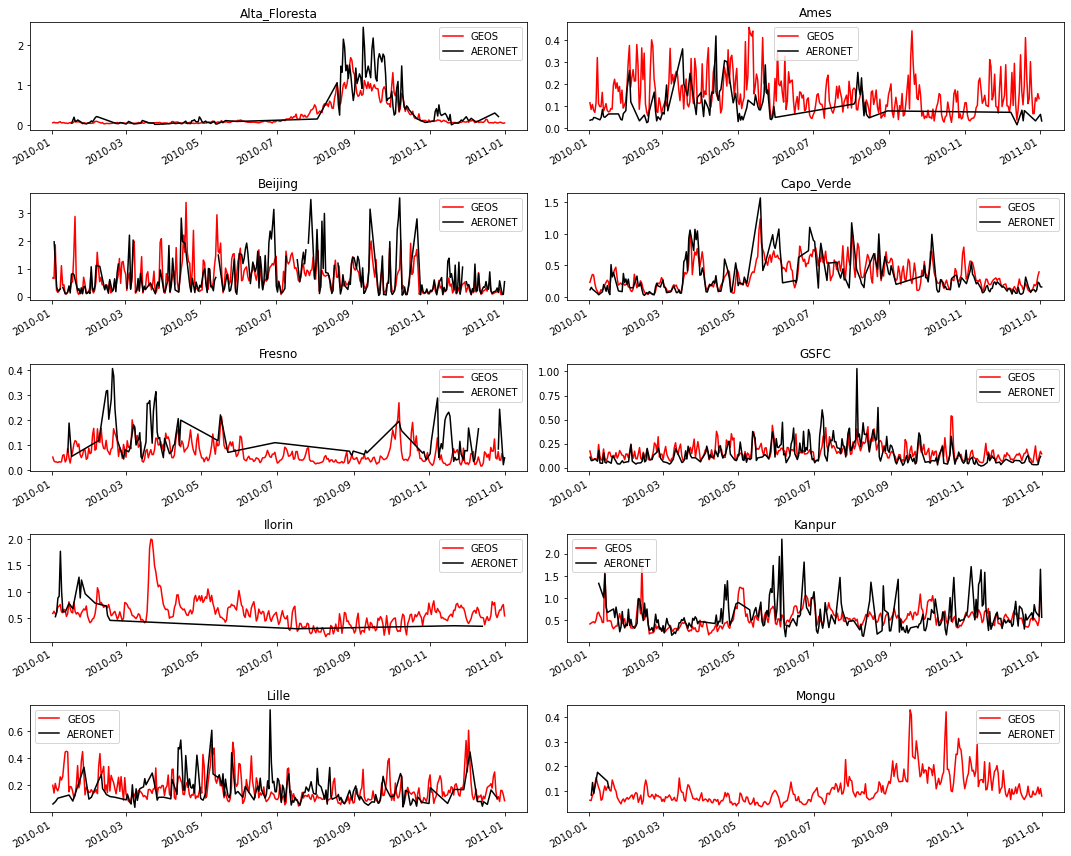

In [15]:
nrows, ncols = calc_rows_columns(num_sites)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,12))

xvals = np.arange(1, num_files+1)

k = 0
for row in range(nrows): 
    for col in range(ncols):
        AOT_550.interp(lat=site_lat[k], lon=site_lon[k]).plot(ax=axes[row, col], color='red', label='GEOS')
        axes[row, col].plot(site_data[k], label='AERONET', color='black')
        axes[row, col].set_title(list_sites[k])
        axes[row, col].yaxis.label.set_visible(False)
        axes[row, col].xaxis.label.set_visible(False)
        axes[row, col].legend()
        k += 1

plt.tight_layout()